# Figure 5 — Serial dependence build-up

In [1]:
include("src/model.jl")
include("src/serialdep.jl")
include("src/fig_serialdep.jl");

In [2]:
win  = π/2
step = π/30

smooth_serialdep(df) = smooth_serialdep_error(
    df; 
    distcol=:abs_dist,
    errcol=:folded_error,
    win=win,
    step=step,
);

In [3]:
using DataFramesMeta

## 1. Data (Barbosa 2020)

In [4]:
data_dir = "../data/Barbosa20Buildup/serial_color/Data"

# load Foster dataset
foster_trials  = read_pickle_windows(data_dir * "/single_trials_foster.pickle")
foster_stimuli = foster_trials[1,:]
foster_reports = foster_trials[2,:]
foster_dists   = foster_trials[3,:]

# load build-up errors as computed by Barbosa
all_folded_errors = read_pickle_windows(data_dir * "/all_f_err.pickle")
;

### 1.1. Build-up

In [5]:
foster_folded_error = all_folded_errors[2]
min_length = minimum(length.(foster_folded_error))

foster_folded_error = [e[1:min_length] for e in foster_folded_error]

buildup_exp_win = 200
buildup_exp_x = collect(1:min_length)
buildup_exp_y = hcat(foster_folded_error...)

buildup_exp_sig = vec(bootstrapsig(buildup_exp_y; fun=mean, sig=0.95, n=1000, dims=[2]))
;

### 1.2. Thirds

In [6]:
df_exp = DataFrame()
for (i, (stimulus, report, dist)) in enumerate(zip(foster_stimuli, foster_reports, foster_dists))
    df = DataFrame(stimulus=stimulus, report=report, dist=dist)
    df.cue = round.(Int, stimulus / π * 180)
    
    df.subject  = fill(i, nrow(df))
    df.trial    = collect(1:nrow(df))
    df.triallen = fill(nrow(df), nrow(df))
    
    df.abs_dist = abs.(df.dist)
    
    df.error        = cdist.(df.report, df.stimulus)
    df.abs_error    = abs.(df.error)
    df.folded_error = sign.(df.dist) .* df.error
    
    append!(df_exp, df)
end

filter!(:abs_error => <(π/4), df_exp);

In [7]:
df_exp_1st = @subset(df_exp, :trial .≤ :triallen ./ 3)
df_exp_3rd = @subset(df_exp, :trial .≥ :triallen .* 2/3);

In [12]:
exp_x, buildup_exp_all, e_exp_all = smooth_serialdep(df_exp)
exp_x, buildup_exp_1st, e_exp_1st = smooth_serialdep(df_exp_1st)
exp_x, buildup_exp_3rd, e_exp_3rd = smooth_serialdep(df_exp_3rd);

## 2. Simulation

In [9]:
using FileIO
df_sim = load("data/fig5.jld2", "df_sim")
filter!(:abs_error => <(π/4), df_sim);

In [ ]:
nsubjects = 11
nrepeats = 3
naug = 100

# timing
timing = TimingCondition("", 1000, 2000)

# main df
df_sim = DataFrame()

for subject in 1:nsubjects
    lg("$subject / $nsubjects")
    
    # reset simulation
    sim = Simulation(1000, 32, 1; β0=100.0, seed=SEEDS[subject], wlr=4e-6)

    # get sequence
    seq = getseq(sim, timing, rand(1:sim.nstimuli); repeat=nrepeats)
    #seq = repeat([(0, iti), (pre_stim, ri), (0, iti), (s, ri)], nrepeats)

    # run simulation
    _, _, rs = run!(sim, seq)

    reports = zeros(sim.nstimuli * nrepeats + 1, naug)
    for i in 1:size(reports,1)
        reports[i,:] = vec(sampletunings(sim.tunings, rs[2i-1,:,:]; N=naug))
    end

    # make helper arrays
    cues = filter(!iszero, map(s -> s[1], seq))

    # build df
    df = DataFrame(
        trial    = repeat(1:length(cues)-1, naug),
        cue_pre  = repeat(cues[1:end-1], naug),
        cue_cur  = repeat(cues[2:end], naug),
    )
    df.subject  = fill(subject,        nrow(df))
    df.triallen = fill(length(cues)-1, nrow(df))

    df.stimulus_pre = sim.stimuli[df.cue_pre]
    df.stimulus_cur = sim.stimuli[df.cue_cur]

    df.report_pre = vec(reports[1:end-1,:])
    df.report_cur = vec(reports[2:end,:])

    # concat with big df
    append!(df_sim, df)
end

compute_dist_error!(df_sim);

In [ ]:
#using FileIO
#save("data/fig5.jld2", "df_sim", df_sim)

In [10]:
filter!(:abs_error => <(π/4), df_sim);

In [11]:
df_sim_1st = @subset(df_sim, :trial .≤ :triallen ./ 3)
df_sim_3rd = @subset(df_sim, :trial .≥ :triallen .* 2/3);

In [13]:
sim_x, buildup_sim_all, e_sim_all = smooth_serialdep(df_sim)
sim_x, buildup_sim_1st, e_sim_1st = smooth_serialdep(df_sim_1st)
sim_x, buildup_sim_3rd, e_sim_3rd = smooth_serialdep(df_sim_3rd);

In [14]:
buildup_sim_win = 50
buildup_sim_x = 1:1:(minimum(unique(df_sim.triallen)) - buildup_sim_win)
buildup_sim_y = zeros(length(buildup_sim_x), length(unique(df_sim.subject)))

for (i, subject) in enumerate(unique(df_sim.subject))
    df = @subset(df_sim, :subject .== subject)

    for (j, t) in enumerate(buildup_sim_x)
        index = (t .< df.trial .< t + buildup_sim_win) .& (df.abs_error .< π/2)
        buildup_sim_y[j,i] = cmean(df.folded_error[index])
    end
end

buildup_sim_sig = vec(bootstrapsig(buildup_sim_y; fun=mean, sig=0.95, n=1000, dims=[2]));

## 3. Final figure

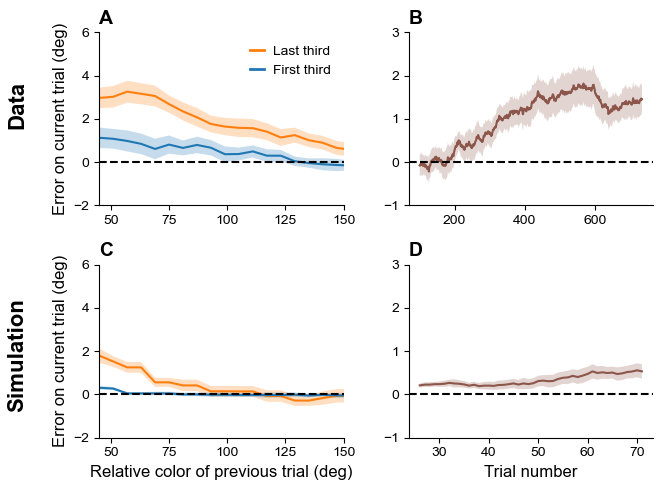

In [18]:
fig = figure("fig5_serialdep_buildup", figsize=(7, 5))

# A: RI
ax = subplot(221)
plt.title("A")

plot_serialdep_error!(ax, exp_x, buildup_exp_3rd; color=get_palette(2), label="Last third")
plot_serialdep_error!(ax, exp_x, buildup_exp_1st; color=get_palette(1), label="First third")
ax.axhline(y = 0, color = "k", linestyle = "--")
ax.set_xlim(45, 150)
ax.set_ylim(-2, 6)
legend() |> legend_shorten_lines!
ax.set_xlabel("")

# B: ITI
ax = subplot(222)
plt.title("B")
plot_serialdep_buildup!(ax, buildup_exp_x .+ buildup_exp_win/2, buildup_exp_y)
ax.set_xlabel("")
ax.set_ylabel("")

# C: RI
ax = subplot(223)
plt.title("C")
plot_serialdep_error!(ax, sim_x, buildup_sim_3rd; color=get_palette(2), label="Last third")
plot_serialdep_error!(ax, sim_x, buildup_sim_1st; color=get_palette(1), label="First third")
ax.axhline(y = 0, color = "k", linestyle = "--")
ax.set_xlim(45, 150)
ax.set_ylim(-2, 6)

# D: ITI
ax = subplot(224)
plt.title("D")
plot_serialdep_buildup!(ax, buildup_sim_x .+ buildup_sim_win/2, buildup_sim_y)
ax.set_ylabel("")


# Update the figure
fig.tight_layout(w_pad=2, rect=(0.05, 0, 0.95, 1)) # (left, bottom, right, top)

# add Data and Simulation annotations
annotate_data_simulation_side!();

In [19]:
fig.savefig("figs/fig5_buildup.pdf"); # not using bbox_inches="tight" to keep space on right

#### Plot overall serialdep

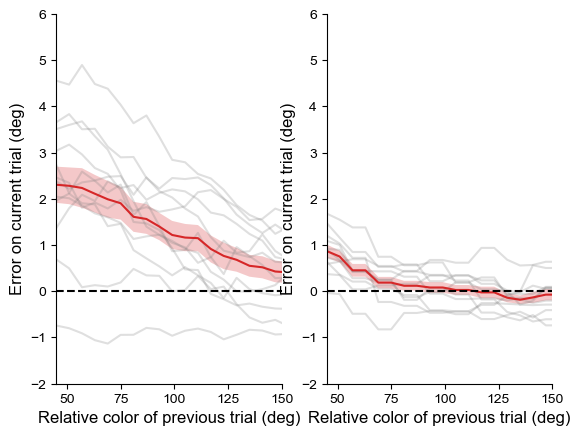

In [20]:
ax = subplot(121)
plot_serialdep_error_by_subject!(ax, exp_x, buildup_exp_all; color=:grey)
plot_serialdep_error!(ax, exp_x, buildup_exp_all; color=get_palette(4))
ax.axhline(y = 0, color = "k", linestyle = "--")
ax.set_xlim(45, 150)
ax.set_ylim(-2, 6)

ax = subplot(122)
plot_serialdep_error_by_subject!(ax, sim_x, buildup_sim_all; color=:grey)
plot_serialdep_error!(ax, sim_x, buildup_sim_all; color=get_palette(4))
ax.axhline(y = 0, color = "k", linestyle = "--")
ax.set_xlim(45, 150)
ax.set_ylim(-2, 6);

In [ ]:
"""
pw_exp = 200
px_exp = 1:1:(minimum(unique(df_exp.triallen)) - pw_exp)
py_exp = zeros(length(px_exp), length(unique(df_exp.subject)))

for (i, subject) in enumerate(unique(df_exp.subject))
    df = filter(:subject => ==(subject), df_exp)

    for (j, t) in enumerate(px_exp)
        index = (t .< df.trial .< t + pw_exp) .& (df.abs_error .< π/2)
        py_exp[j,i] = cmean(df.folded_error[index])
    end
end

py_exp_sig = bootstrapsig(py_exp) |> vec
;
""";

In [ ]:
"Compute distances and errors for data given in `df`."
function compute_dist_error_old!(df; folded_error_distcol=:dist)
    # check that colnames are present in df
    cols = [:cue_pre, :cue_cur, :report_pre, :report_cur]
    @assert all(string(c) in names(df) for c in cols)

    # add mean report for each cue, separately for current and previous cues
    add_mean_report!(df, :cue_pre, :report_pre)
    add_mean_report!(df, :cue_cur, :report_cur)
    
    # distance
    df.dist     = cdist.(df.stimulus_pre, df.stimulus_cur)
    df.abs_dist = abs.(df.dist)

    df.dist_report     = cdist.(df.report_pre, df.report_cur)
    df.abs_dist_report = abs.(df.dist_report)

    df.dist_report_to_mean     = cdist.(df.report_pre, df.mean_report_cur)
    df.abs_dist_report_to_mean = abs.(df.dist_report_to_mean)

    # error
    df.error = cdist.(df.report_cur, df.stimulus_cur)
    df.abs_error = abs.(df.error)
    
    df.error_to_mean = cdist.(df.report_cur, df.mean_report_cur)
    df.abs_error_to_mean = abs.(df.error_to_mean)
    
    # folded error
    s = sign.(df[:,folded_error_distcol]) 
    df.folded_error         = s .* df.error
    df.folded_error_to_mean = s .* df.error_to_mean
    
    return df
end;